In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csaps    
import pandas as pd
    
from lightkurve.search import search_lightcurvefile

In [2]:
# %matplotlib notebook

%matplotlib inline

# Filter and normalization function definitions

In [3]:
def normalize_region(wl, flux, ferr, sds, plot_q=True, ss_smo=1e-3):
    
    __, gi = stdFiltIt(wl, np.copy(flux), 
                       np.ones_like(flux), 
                       sds, smo=ss_smo, plot_q=plot_q)

    cont_fit = csaps.CubicSmoothingSpline(wl[gi], flux[gi], smooth=ss_smo)(wl)

    if plot_q:
        
        plt.figure(figsize=(10, 5))
        plt.plot(wl, flux, '.-k')
        plt.plot(wl, cont_fit, '-r')
        plt.title('Fit')
        plt.xlabel('time')
        plt.ylabel('Flux')
        
        plt.grid(1)
        
        plt.show()
    
    #####################################
    # Normalize continuum

    flux_norm = flux / cont_fit
    
    ferr_norm = ferr / cont_fit

    if plot_q:
        
        plt.figure(figsize=(10, 5))
        #plt.plot(wl, flux_norm, '.-k')
        plt.plot(wl, flux_norm, '-', c=[0.5, 0.5, 0.5], linewidth=1, label='Flux')
        
        if 1:
            plt.fill_between(wl, flux_norm - ferr_norm, flux_norm + ferr_norm, 
                             step='mid', 
                             color=[0.85, 0.85, 0.85], label='Flux Error')
        
        plt.axhline(1.0, color='m', linewidth=1, label='Continuum')
            
        plt.title('Normalized')
        
        plt.xlabel('time [day]')
        plt.ylabel('Flux [ppt]')
        
        plt.grid(1)
        
        plt.show()
    
    return cont_fit, flux_norm, ferr_norm


def wlr2ir(wl, wl_bounds):
    
    line_idx_bnds = [0, 0]

    line_idx_bnds[0] = np.argwhere(np.abs(wl - wl_bounds[0]) == np.nanmin(np.abs(wl - wl_bounds[0])))
    line_idx_bnds[1] = np.argwhere(np.abs(wl - wl_bounds[1]) == np.nanmin(np.abs(wl - wl_bounds[1])))

    # What indicies span within the wavelength bounds?
    return np.arange(line_idx_bnds[0], line_idx_bnds[1] + 1)


def stdFiltIt(wl, arr_1d, weights_1d, sdms, smo, plot_q):
    
    if plot_q:
        plt.figure(figsize=(10, 5))
        plt.title('Filter plot')
        plt.plot(wl, arr_1d, '.k')

    fit = arr_1d + np.nan
    
    for sdm in sdms:

        gi = np.logical_and(np.isfinite(weights_1d), np.isfinite(arr_1d))
        
        fit = csaps.CubicSmoothingSpline(wl[gi], arr_1d[gi], smooth=smo)(wl)

        dy_sd = np.std(arr_1d[gi] - fit[gi]) * sdm

        gi = np.logical_and(np.abs(arr_1d - fit) <= dy_sd, gi)

        if plot_q:
            plt.plot(wl[np.logical_not(gi)], arr_1d[np.logical_not(gi)], 'xr')
            plt.plot(wl, fit + dy_sd, ':g')
            plt.plot(wl, fit - dy_sd, ':r')
            plt.grid(True)

        arr_1d[np.logical_not(gi)] = np.nan

    if plot_q:
        plt.show()

    return arr_1d, gi

In [3708]:
hsps = pd.read_excel("hsp_60_400_days_v2.xlsx")
hsp_kic = hsps['kic']
hsp_per = hsps['period (d)']
hsp_Rp = hsps['r_planet (earth)']
hsp_Rs = hsps['r_star (sun)']
hsp_dur = hsps['transit_dur (h)']
hsp_depth = hsps['transit_depth (ppm)']
hsp_smaxis = hsps['sm_axis (au)']
hsp_t0 = hsps['t0 (bjd)']
hsp_incl = hsps['incl (deg)']
hsp_eccen = hsps['eccen']
hsp_koi = hsps['koi']
hsp_smass = hsps['smass (sun)']

table = pd.read_excel('KeplerCumulative.xlsx')

all_kics = table['kepid'][:]
all_kepoi_temp = table['kepoi_name'][:]
all_t0_catalog_bjd = table['koi_time0'][:]
all_period_catalog = table['koi_period'][:]
all_duration_catalog = table['koi_duration'][:]

In [3709]:
all_kepoi = [float(x[1:]) for x in all_kepoi_temp]

In [3710]:
ind = 4

In [3711]:
all_t0_bkjd = []
all_period_day = []
all_duration_day = []

name = hsp_koi[ind] #Must be an KIC integer
interest_idx = -1
print("TARGET NAME: " + str(name))


kepoi_spec = int(name)
print("SEARCH INDEX: " + str(kepoi_spec))

for_search = hsp_kic[ind]


print("Using Kepler Catalog, list of all in same system follows: ")

for i in range(len(all_kepoi)):
    if (kepoi_spec == int(all_kepoi[i])): #just authomatically finds other Kepler planets in same system and gets their values
        if (name != all_kepoi[i]):
            all_t0_bkjd.append(all_t0_catalog_bjd[i])
            all_period_day.append(all_period_catalog[i])
            all_duration_day.append(all_duration_catalog[i]/24)
            print(all_kepoi[i])

t0 = hsp_t0[ind]
per = hsp_per[ind]
dur = hsp_dur[ind] / 24

            
all_t0_bkjd.append(t0)
all_period_day.append(per)
all_duration_day.append(dur / 24)
interest_idx = len(all_t0_bkjd) - 1

print("target_name = " + str(for_search))
print("all_t0_bkjd = " + str(all_t0_bkjd))
print("all_period_day = " + str(all_period_day))
print("all_duration_day = " + str(all_duration_day))
print("interest_idx = " + str(interest_idx))

target_name = for_search
all_t0_bkjd = [float(i) for i in all_t0_bkjd]
print(all_t0_bkjd)

TARGET NAME: 701.04
SEARCH INDEX: 701
Using Kepler Catalog, list of all in same system follows: 
701.01
701.02
701.03
701.05
target_name = 9002278
all_t0_bkjd = [2455013.812, 2455003.922, 2454983.412, 2454967.651, 2455423]
all_period_day = [18.16407304, 5.71489692, 122.3858681, 12.4418003, 267.291]
all_duration_day = [0.1223125, 0.09821666666666667, 0.2967916666666667, 0.14883333333333335, 0.013520833333333334]
interest_idx = 4
[2455013.812, 2455003.922, 2454983.412, 2454967.651, 2455423.0]


# Or download a light curve

**Search for data of a specific target**

In [2115]:
# target_name = '8692861'
# target_name = '8120608'

In [3712]:
for i in range(len(all_t0_bkjd)):
    
    t0i = all_t0_bkjd[i]
    
    if t0i < 1e4:
        
        all_t0_bkjd[i] = bkjd2bjd(t0i)
print(all_t0_bkjd)

[2455013.812, 2455003.922, 2454983.412, 2454967.651, 2455423.0]


In [3714]:


res = search_lightcurvefile(target_name, radius=None, 
                            cadence='long', #
                            #cadence='short', 
                            mission=('Kepler'),#, 'K2', 'TESS'), 
                            quarter=None, month=None, 
                            campaign=None, 
                            #campaign=16, 
                            sector=None, 
                            limit=None,
                            #limit=10,
                           )

res

#,observation,target_name,productFilename,distance
0,Kepler Quarter 1,kplr009002278,kplr009002278-2009166043257_llc.fits,0.0
1,Kepler Quarter 2,kplr009002278,kplr009002278-2009259160929_llc.fits,0.0
2,Kepler Quarter 3,kplr009002278,kplr009002278-2009350155506_llc.fits,0.0
3,Kepler Quarter 4,kplr009002278,kplr009002278-2010078095331_llc.fits,0.0
4,Kepler Quarter 5,kplr009002278,kplr009002278-2010174085026_llc.fits,0.0
5,Kepler Quarter 6,kplr009002278,kplr009002278-2010265121752_llc.fits,0.0
6,Kepler Quarter 7,kplr009002278,kplr009002278-2010355172524_llc.fits,0.0
7,Kepler Quarter 8,kplr009002278,kplr009002278-2011073133259_llc.fits,0.0
8,Kepler Quarter 9,kplr009002278,kplr009002278-2011177032512_llc.fits,0.0
9,Kepler Quarter 10,kplr009002278,kplr009002278-2011271113734_llc.fits,0.0


**Download the data and stitch all the quartly data together into one light curve**

In [3715]:
lc = res.download_all(quality_bitmask='hard')

try:
    lc = lc.PDCSAP_FLUX.stitch()
except:
    pass

lc

KeplerLightCurve(ID: 9002278)

# Check the size of the data array

If the array is over 50,000 elements, the following processes will take a long time. If too long, the processes also might fail due to running out of memory (dependent on how much memory your PC has).

In [3640]:
len(lc.time)

60987

If the size of the array is too large, you should bin the data to reduce its size.

Binning will combine datapoints to make a smaller dataset.

For example, 

T = [t1, t2, t3, t4, t5, t6, ...]

binning T by 2 would combine the elements in T like so,

T_binned_by_2 = [mean(t1, t2), mean(t3, t4), mean(t5, t6), ...]

such that the bined array has length of len(T) / 2

In [3716]:
if 0:
    lc = lc.bin(binsize=5)

# Filter NaN's out of the dataset

In [3717]:
lc = lc.remove_nans()

time, flux, flux_err = lc.time, lc.flux, lc.flux_err

if 1:
    time = np.array(lc.astropy_time.value)# - 2400000.5

In [3718]:
lc.astropy_time

<Time object: scale='tdb' format='jd' value=[2454964.51275952 2454964.53319391 2454964.57406238 ... 2456423.96109876
 2456423.98153303 2456424.00196749]>

New array length after binning (if binning enabled)

In [3564]:
len(time)

62386

# Plot the original lightcurve data

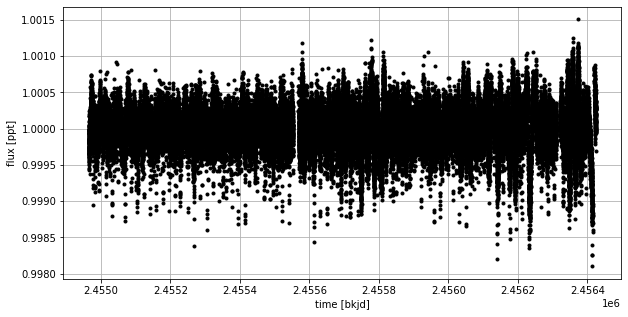

In [3719]:
plt.figure(figsize=(10, 5))
plt.plot(time, flux, '.k')
plt.grid(1)
plt.xlabel('time [bkjd]')
plt.ylabel('flux [ppt]');
plt.show(block=0)

In [3720]:
def bjd2bkjd(bjd):
    
    return bjd - 2454833.0


def bkjd2bjd(bkjd):
    
    return bkjd + 2454833.0


def mask_mulit_transits(t0_bkjd, period_day, duration_day, time_bkjd, flux, 
                        lc=None, return_index=True):
    
    gi = ~np.ones(len(flux), dtype=bool)
    
    for p, t, d in zip(period_day, t0_bkjd, duration_day):
        
        
        gi0 = mask_transits(t, p, d, 
                            time_bkjd, flux, 
                            lc=None, return_index=True)
        
        #print(p, t, len(gi0) - np.sum(gi0))
        
                    
        gi = gi | gi0
                    
    return gi

def get_transit_times(t0_bkjd, period_day, duration_day, time_bkjd, flux):
    
    t0f_bkjd = np.copy(t0_bkjd)
   
    while t0f_bkjd > time_bkjd[0]:
       
        t0f_bkjd -= period_day
        
    #t0f_bkjd += period_day
        
    while t0f_bkjd < time_bkjd[0]:
       
        t0f_bkjd += period_day
        
    #t0f_bkjd -= period_day
       
    return np.arange(t0f_bkjd, time_bkjd.max(), step=period_day)
    

def mask_transits(t0_bkjd, period_day, duration_day, time_bkjd, flux, 
                  lc=None, return_index=True):
   
    # http://www.raa-journal.org/docs/Supp/ms4253tab1.txt
       
    if lc != None:
        
        time_bkjd = np.array(lc.astropy_time.value)

        flux = lc.flux
   
    t0f_bkjd = np.copy(t0_bkjd)
      
    tots_bkjd = get_transit_times(t0f_bkjd, period_day, duration_day, time_bkjd, flux)
   
    # For each tranist find all datapoints within the tranist duration window
   
    ntot_idx = np.ones(len(flux), dtype=bool)
   
    for tot in tots_bkjd:
       
        tot_idx = (time_bkjd > tot - duration_day / 2) & (time_bkjd < tot + duration_day / 2)
       
        ntot_idx = ntot_idx & ~tot_idx
    
    if return_index:
        return ~ntot_idx # Returns where transits occur
    else:
        return time_bkjd[ntot_idx], flux[ntot_idx]


def plot_transits_v0(t0_bkjd, period_day, duration_day, time_bkjd, flux):
   
    # http://www.raa-journal.org/docs/Supp/ms4253tab1.txt
   
    #time_bkjd = np.array(lc.astropy_time.value)
    
#     if time_bkjd[0] > 2400000.5:
        
#         time_bkjd = time_bkjd - 2400000.5
   
    #flux = lc.flux
   
    t0f_bkjd = np.copy(t0_bkjd)
   
    tots_bkjd = get_transit_times(t0f_bkjd, period_day, duration_day, time_bkjd, flux)
   
    # For each tranist find all datapoints within the tranist duration window
   
    ntot_idx = np.ones(len(flux), dtype=bool)
   
    for tot in tots_bkjd:
       
        tot_idx = (time_bkjd > tot - duration_day / 2) & (time_bkjd < tot + duration_day / 2)
       
        ntot_idx = ntot_idx & ~tot_idx
        
        plt.axvline(tot, c='r')
       
    plt.plot(time_bkjd[ntot_idx], flux[ntot_idx], '.k')
    plt.plot(time_bkjd[~ntot_idx], flux[~ntot_idx], '.r')
    
    plt.xlabel('time [day]')
    plt.ylabel('flux [ppt]');
    plt.show(block=0)
    
    
def plot_mp_transits_v0(t0_bkjd0, period_day0, duration_day, time_bkjd, flux, toi):
   
    # http://www.raa-journal.org/docs/Supp/ms4253tab1.txt
    
    t0f_bkjd0 = np.copy(t0_bkjd0)
   
    plt.figure(figsize=(10, 5))
    #plt.plot(time_bkjd, flux, '.r')
    cw = ['r','g','c', 'b', 'm']
    
    for it in np.arange(len(period_day0)):
        
        #print(it, period_day0, t0f_bkjd0)
        
        period_day, t0f_bkjd = period_day0[it], t0f_bkjd0[it]

        tots_bkjd = get_transit_times(t0f_bkjd, period_day, duration_day[it], time_bkjd, flux)

        # For each tranist find all datapoints within the tranist duration window
        ntot_idx = np.ones(len(flux), dtype=bool)

        for tot in tots_bkjd:

            tot_idx = (time_bkjd > tot - duration_day[it] / 2) & (time_bkjd < tot + duration_day[it] / 2)

            ntot_idx = ntot_idx & ~tot_idx

            plt.axvline(tot, c=cw[it])

        if it == 0:
            plt.plot(time_bkjd[ntot_idx], flux[ntot_idx], '.-k')
            
        if it == toi:
            plt.plot(time_bkjd[~ntot_idx], flux[~ntot_idx], '.', c=cw[it], 
                     label='P='+ str(np.around(period_day, 1)) + '  t0='+ str(np.around(t0f_bkjd, 1)) + '  d='+ str(np.around(duration_day[it], 3)) + ' (TOI)')
        
        else:
            plt.plot(time_bkjd[~ntot_idx], flux[~ntot_idx], '.', c=cw[it], 
                     label='P='+ str(np.around(period_day, 1)) + '  t0='+ str(np.around(t0f_bkjd, 1)) + '  d='+ str(np.around(duration_day[it], 3)))
        

    plt.legend()
    plt.xlabel('time [day]')
    plt.ylabel('flux [ppt]');
    plt.show(block=0)

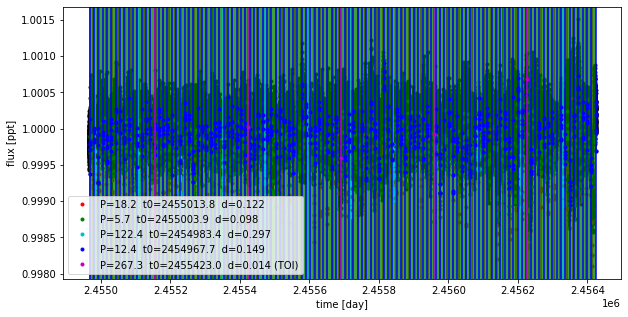

In [3721]:
# interest_idx = 4

plot_mp_transits_v0(np.array(all_t0_bkjd), all_period_day, all_duration_day, time, flux, interest_idx)

# Estimate the time gap threshold

During the fitting and filtering routine, we need to separate the data into different chunks wherever there are time gaps in the data. Time gaps are periods of time where data was not taken. For example, if the average time between each measurements is 0.1 days, then any data that is missing for over 0.1 days is a gap. 

This process is required because the fitting process has trouble with the edges of the data. If you dont split the data into peices, the fitter will not properly fit between the two time spans, which causes major issues.

Use the info below to determine the proper time gap threshold for your data.

In [3722]:
# Determine time gap threshold

print('Time Stats:\nMin = ' + str(np.nanmin(np.diff(time))) +
      '\nMax = ' + str(np.nanmax(np.diff(time))) +
      '\nMedian = ' + str(np.nanmedian(np.diff(time))) +
      '\nSD = ' + str(np.nanstd(np.diff(time))))

#time_gap_thresh = np.nanstd(np.diff(time)) * 10
time_gap_thresh = np.nanmedian(np.diff(time)) * 3


print(time_gap_thresh)

Time Stats:
Min = 0.020428230054676533
Max = 15.835754486266524
Median = 0.02043368946760893
SD = 0.1044001498244735
0.061301068402826786


# Split, filter, and fit functions

# Split, filter, and fit

The light curve will be split into pieces based on the time gap threshold, then filtered based on the standard deviations given, then fit the data with an optimally smoothed fit. After all the fits are meade to each chunk, the data is joined back together, then normalized. The output will be a normalized lightcurve.



From the main fitter function "kepler_spline.py":

Computes the best-fit Kepler spline across a break-point spacings.
Some Kepler light curves have low-frequency variability, while others have
very high-frequency variability (e.g. due to rapid rotation). Therefore, it is
suboptimal to use the same break-point spacing for every star. This function
computes the best-fit spline by fitting splines with different break-point
spacings, calculating the Bayesian Information Criterion (BIC) for each
spline, and choosing the break-point spacing that minimizes the BIC.
This function assumes a piecewise light curve, that is, a light curve that is
divided into different segments (e.g. split by quarter breaks or gaps in the
in the data). A separate spline is fit for each segment.

In [3723]:
def meas_bic(flux, cont_fit):

    sigma = np.median(np.diff(flux)) * 1.48 / np.sqrt(2)


    ssr = np.sum( (flux - cont_fit)**2 )


    npoints = len(flux)


    penalty_coeff = 1.0


    nparams = 1.0 # number of knots + degree of spline - 1

    # The following term is -2*ln(L), where L is the likelihood of the data
    # given the model, under the assumption that the model errors are iid
    # Gaussian with mean 0 and standard deviation sigma.
    likelihood_term = npoints * np.log(2 * np.pi * sigma**2) + ssr / sigma**2

    # Bayesian information criterion.
    bic = likelihood_term + penalty_coeff * nparams * np.log(npoints)
    
    return bic



def meas_sigdif(time, flux, weights, cont_fit, sigma_i):

    #df = flux / cont_fit
    
    #sigma_f = np.std(np.diff(df)) #* 1.48 / np.sqrt(2)
    
    sigma_f = meas_sig(time, flux / cont_fit, weights, plot_q=0)
    
    return (sigma_i - sigma_f)**2

In [3724]:
def split(all_time, all_flux, gap_width=0.75, dft=0.05, index_only=False):
    """Splits a light curve on discontinuities (gaps).
    This function accepts a light curve that is either a single segment, or is
    piecewise defined (e.g. split by quarter breaks or gaps in the in the data).
    Args:
    all_time: Numpy array or list of numpy arrays; each is a sequence of time
        values.
    all_flux: Numpy array or list of numpy arrays; each is a sequence of flux
        values of the corresponding time array.
    gap_width: Minimum gap size (in time units) for a split.
    Returns:
    out_time: List of numpy arrays; the split time arrays.
    out_flux: List of numpy arrays; the split flux arrays.
    """
    
    import collections
    
    if index_only:
        idx = np.arange(len(all_time), dtype=int)
    
    # Handle single-segment inputs.
    # We must use an explicit length test on all_time because implicit conversion
    # to bool fails if all_time is a numpy array, and all_time.size is not defined
    # if all_time is a list of numpy arrays.
    if len(all_time) > 0 and not isinstance(all_time[0], collections.Iterable):  # pylint:disable=g-explicit-length-test
        
        all_time = [all_time]
        all_flux = [all_flux]

    out_time = []
    out_flux = []
    out_idx = []
    for time, flux in zip(all_time, all_flux):

        start = 0

        for end in range(1, len(time) + 1):

            splitit = 0
            # Choose the largest endpoint such that time[start:end] has no gaps.
            if end == len(time):
                splitit = 1
                
            elif (time[end] - time[end - 1] > gap_width):
                splitit = 1
                
            elif np.abs(flux[end] - flux[end - 1]) > dft:
                splitit = 1

            if splitit:
                
                if index_only:
                    out_idx.append(idx[start:end])
                else:
                    out_time.append(time[start:end])
                    out_flux.append(flux[start:end])
                start = end

    if index_only:
        return out_idx
    else:
        return out_time, out_flux

In [3725]:
def meas_sig(time, flux, weights, plot_q=False):
    
    df0 = np.diff(flux)
    
    #df = sigma_clip(df0, sigma=8, maxiters=1)
    
    #df = sigma_clip(df, sigma=5, maxiters=2)
    
    #df = sigma_clip(df, sigma=3, maxiters=2)
    
    gi = np.ones(len(df0), dtype=bool)
    
    for sdm in [8, 5, 3]:
        
        sd = np.std(df0[gi])
        
        gi = gi & ((df0 > -sd * sdm) & (df0 < sd * sdm))
    
    
    if plot_q:
        
        x = np.copy(time[:-1])
        
        #__, gi, __ = np.intersect1d(df0, df, return_indices=1)
        
        #gi = np.sort(gi)
        
        plt.figure(figsize=(10, 4))
        plt.title(str(np.median(np.abs(df0))))
        plt.plot(x, df0, '.k', label='Orig dF')
        plt.plot(x[gi], df0[gi], '.g', label='Final dF')
        plt.legend()
        
    return np.median(np.abs(df0[gi]))
        

def meas_sig_old(time, flux, weights, plot_q=False):
    
    from astropy.stats import sigma_clip
    
    df = np.diff(flux)
    
    x = np.copy(time[:-1]) #np.arange(len(df))
    
    dff1 = csaps.CubicSmoothingSpline(x, df, smooth=0.1, weights=weights[:-1],)(x)

    
#     print('dff1', dff1)
    
    dfn = df - dff1
    
    dfnf = np.copy(dfn)
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(x, df, '.k', label='Orig dF')
#     plt.plot(x, dff1, '-c', label='dF fit 1')
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(x, dfn, '.k', label='Orig dF')

    for sd in [5]:

        dfnf = sigma_clip(dfnf, sigma=sd, maxiters=2)

    __, gi, __ = np.intersect1d(dfn, dfnf, return_indices=1)

    gi = np.sort(gi)
    
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(x[gi], dfn[gi], '.k', label='Orig dF')
    
#     try:

    dff = csaps.CubicSmoothingSpline(x[gi], df[gi], smooth=0.1, weights=weights[:-1][gi],)(x)
#     except:
        
#         print('FAIL', len(x), len(gi))
        
#         #FAIL 271 270 36338 -36608
#         #FAIL 271 270 36338 -36608
        
#         return

    dfn = df - dff

    if plot_q:
        plt.figure(figsize=(10, 4))
        plt.plot(x, df, '.k', label='Orig dF')
        plt.plot(x, dff1, '-c', label='dF fit 1')
        plt.plot(x, dff, '-m', label='dF fit 2')
        plt.legend()
    
    
    for sd in [5, 3]:
        
        dfn = sigma_clip(dfn, sigma=sd, maxiters=5)

    if plot_q:
        plt.figure(figsize=(10, 7))
        plt.title('RMS = ' + str(np.std(dfn)))
        plt.plot(x, dfn, '.k')
        
    return np.std(dfn)

In [3726]:
def filt_ssfit(time, flux, weights, gi_mask, smo, sds, return_filt_index=False, plot_q=False):
    
#     from csaps import UnivariateCubicSmoothingSpline as ss
    
    flux_fit = csaps.CubicSmoothingSpline(time[gi_mask], flux[gi_mask], smooth=smo, weights=weights[gi_mask])(time)

    df = flux - flux_fit

    dff = np.copy(df)

#     for sd in sds:

#         dff = sigma_clip(dff, sigma=sd, maxiters=3)

#     __, gi, __ = np.intersect1d(df, dff, return_indices=1)

#     gi = np.sort(gi)
    
#     bi = np.ones(len(time), dtype=bool)
#     bi[gi] = False
#     gi = ~bi

    gi = np.copy(gi_mask)
    
    gi_cnt_0 = np.sum(gi)

    for sdm in sds:

        sd = np.std(dff[gi])

        gi_new = ((dff > -sd * sdm) & (dff < sd * sdm))
        
        if np.sum(gi_new) < gi_cnt_0 * 0.5:
            
            print('Filter might be too strong. Attempted to filter >50% of the points in a section. Not applying this filter.')
            break
        
        gi = gi & gi_new
        
    
    # Apply mask
    #gi = gi & gi_mask
    bi = ~gi
    
    cf = csaps.CubicSmoothingSpline(time[gi], flux[gi], smooth=smo, weights=weights[gi])(time)
    
    if plot_q:
        
        # Show the filter plot
        plt.figure(figsize=(10, 7))
        plt.title('Filter Stage (single)')
        plt.plot(time, flux, '.k')
        plt.plot(time[bi], flux[bi], 'xr')
        plt.plot(time, cf, '-m')
        plt.show()
        plt.pause(0.1)

    if return_filt_index:
        return cf, bi
    else:
        return cf

    
def iter_filt_ssfit(time, flux, weights, gi_mask, smo, sds, iters=3, return_filt_index=False, plot_q=False):
    
    time2, flux2 = np.copy(time), np.copy(flux)
    
    gi = np.copy(gi_mask) #ones(len(time), dtype=bool)
    
    for i in range(iters):
        
        cf, bi = filt_ssfit(time2, flux2, weights, 
                            gi, smo, sds, 
                            return_filt_index=True, 
                            plot_q=0)
        
        gi = ~bi
        
        
    if plot_q:
        
        # Show the filter plot
        plt.figure(figsize=(10, 7))
        plt.title('Filter Stage')
        plt.plot(time, flux, '.k')
        plt.plot(time[~gi_mask], flux[~gi_mask], '.', c=[0,1,0,0.8])
        plt.plot(time[~gi & gi_mask], flux[~gi & gi_mask], 'xr')
        plt.plot(time, cf, '-m')
        plt.show()
        plt.pause(0.1)
        
    if return_filt_index:
        return cf, ~gi
    else:
        return cf

In [3727]:
def normlc(time, flux, smooth_params_to_try, fit_sds, time_gap_thresh, 
           mask_transit_q, t0, p, duration, 
           flux_gap_thresh=0.005, plot_q=False):
    
    
    ####################################################################################
    # Split the light curve into sections based on time and flux gaps 
    
    all_time, all_flux = split(time, flux, 
                               gap_width=time_gap_thresh, 
                               dft=flux_gap_thresh)

    print('Data broken into ' + str(len(all_time)) + ' sections')

    if plot_q:
        
        plt.figure(figsize=(10, 7))
        plt.title('Data broken into ' + str(len(all_time)) + ' sections')

        for ci in np.arange(len(all_flux)):

            plt.plot(all_time[ci], all_flux[ci], '.')
        
        plt.show()
        plt.pause(1.0)
        
        
    # Cut sections that are lest than 50 points long
    cnt = np.array([len(all_time[i]) for i in range(len(all_time))])
    
    gi = cnt > 30
    
    all_time0, all_flux0 = np.copy(all_time), np.copy(all_flux)
    
    all_time, all_flux = [], []
    for i in np.arange(len(all_time0)):
        
        if gi[i]:
            all_time.append(all_time0[i])
            all_flux.append(all_flux0[i])
        
        

    ####################################################################################
    # Fit each section
    
    smos = np.copy(smooth_params_to_try) #np.linspace(0.999, 1-1e-10, 200)
    
    cont_fit, time_norm, flux_norm, outliers = np.array([]), np.array([]), np.array([]), np.array([])
    cont_fit_list, flux_norm_list, outliers_list = [], [], []
    
    for cn in range(len(all_time)):
    #for cn in range(1):

        # Mask the transit
        if mask_transit_q:
            
            transit_idx = mask_transits(t0_bkjd=t0, period_day=p, duration_day=duration, 
                                        time_bkjd=all_time[cn], 
                                        flux=all_flux[cn], 
                                        lc=None, return_index=True)
        else:

            transit_idx = np.zeros(len(all_time[cn]), dtype=bool)
            

        weights = np.float64(~transit_idx)
        
        weights[weights==0.0] = 1e-5
        
        bics = np.ones_like(smos)

        sigma = meas_sig(all_time[cn][~transit_idx], all_flux[cn][~transit_idx], weights, plot_q=0)

        for i, smo in enumerate(smos):

            # Make the fit
            cont_fit_tmp = iter_filt_ssfit(all_time[cn], 
                                           all_flux[cn], weights, 
                                           ~transit_idx, 
                                           smo, sds=fit_sds, 
                                           return_filt_index=0, 
                                           plot_q=0)
            
            # Measure the fit reliabillity based on some metric
            bics[i] = meas_sigdif(all_time[cn][~transit_idx], 
                                  all_flux[cn][~transit_idx], 
                                  cont_fit_tmp[~transit_idx], 
                                  sigma_i=sigma)


        # Determine the best smoothing param
        bv = np.argmin(bics)

        idx = np.arange(3) - 1

        idx = bv + idx

        pf_fail = True
        if (idx[0] < 0) | (idx[-1] > len(smos)-1):
            
            bsmo = smos[bv]
            
        else:
            
            pfc = np.polyfit(smos[idx], bics[idx], 2)

            bsmo = - pfc[1] / (2 * pfc[0])
            
            pf_fail = False

        
        if 0:#plot_q:

            plt.figure(figsize=(10, 7))
            plt.title('Sigma difference results  |  Section ' + str(cn) + ' | Best smoothing param = ' + str(bsmo))
            plt.plot(smos, bics, '.k', label='Sigma')
            
            if not pf_fail:
                plt.plot(smos[idx], np.polyval(pfc, smos[idx]), '-m', label='Sigma fit')
                plt.plot(bsmo, np.polyval(pfc, bsmo), '*g', label='Best match')
                
            plt.show()
            
        
        # Make the final fit using the solved smoothing param
        cont_fit_tmp, outliers_tmp = iter_filt_ssfit(all_time[cn], 
                                                     all_flux[cn], 
                                                     ~transit_idx, 
                                                     bsmo, sds=fit_sds, 
                                                     return_filt_index=1, 
                                                     plot_q=0)
        
        
        flux_norm_tmp = all_flux[cn] / cont_fit_tmp
        
        
        cont_fit_list.append(cont_fit_tmp)
        
        flux_norm_list.append(flux_norm_tmp)
        
        outliers_list.append(outliers_tmp)
        
        
        time_norm = np.concatenate((time_norm, all_time[cn]))
        
        cont_fit = np.concatenate((cont_fit, cont_fit_tmp))
        
        flux_norm = np.concatenate((flux_norm, flux_norm_tmp))
        
        outliers = np.concatenate((outliers, outliers_tmp))
        
        
    if plot_q:
        
        # Mask the transit
        if mask_transit_q:

            transit_idx = mask_transits(t0_bkjd=t0, period_day=p, duration_day=duration, 
                                        time_bkjd=time_norm, flux=flux_norm, 
                                        lc=None, return_index=True)
        else:

            transit_idx = np.zeros(len(all_time[cn]), dtype=bool)

        plt.figure(figsize=(10, 7))
        
        #plt.plot(time_norm, flux_norm, '.k')
        plt.plot(time_norm, flux_norm, '.k')
        
        if mask_transit_q:
            plt.plot(time_norm[transit_idx], flux_norm[transit_idx], '.', 
                     c=[0,1,0,0.8], label='Transit (Area Masked During Fit)')
        
        plt.grid(1)
        plt.show()
        
    return time_norm, flux_norm, cont_fit, outliers

In [3728]:
def rms(y):

    gi = np.isfinite(y)

    y = y[gi]

    return np.sqrt(np.mean(y ** 2))

In [3729]:
from astropy.stats import sigma_clip

In [3730]:
np.std(lc.flux) * 5, time_gap_thresh * 10

(0.0014695514983031899, 0.6130106840282679)

Data broken into 56 sections


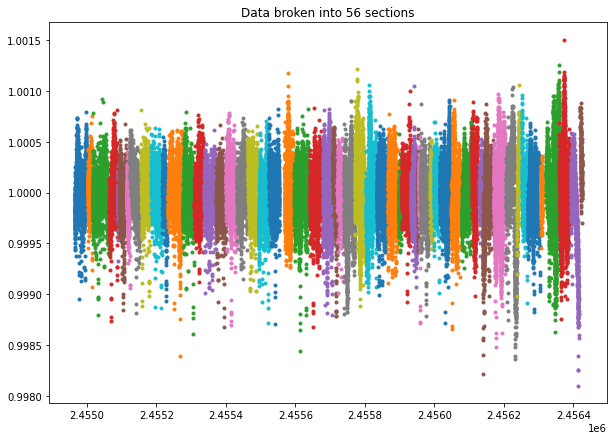

In [3731]:
#time_gap_thresh = np.nanstd(np.diff(np.array(lc.astropy_time.value))) * 10

all_time, all_flux = split(time, flux,  
                           gap_width=time_gap_thresh * 10, 
                           dft=np.std(lc.flux) * 5.0)


# all_time, all_flux = split(time, flux,  
#                            gap_width=time_gap_thresh * 3, 
#                            dft=np.std(lc.flux) * 3)
       
plot_q = 1
print('Data broken into ' + str(len(all_time)) + ' sections')

if plot_q:

    plt.figure(figsize=(10, 7))
    plt.title('Data broken into ' + str(len(all_time)) + ' sections')

    for ci in np.arange(len(all_flux)):

        plt.plot(all_time[ci], all_flux[ci], '.')

    plt.show()
    plt.pause(1.0)
    
all_time0, all_flux0 = np.copy(all_time), np.copy(all_flux)

In [3732]:
# Cut sections that are lest than 50 points long
# cnt = np.array([len(all_time[i]) for i in range(len(all_time))])

# gi = cnt > 30

# all_time0, all_flux0 = np.copy(all_time), np.copy(all_flux)

all_time, all_flux = [], []
for i in np.arange(len(all_time0)):
    
    transit_idx = mask_mulit_transits(all_t0_bkjd, all_period_day, duration_day=all_duration_day, 
                                      time_bkjd=all_time0[i], 
                                      flux=all_flux0[i], 
                                      lc=None, 
                                      return_index=True)
    
    gi = len(all_time0[i][~transit_idx]) > 30

    if gi:
        all_time.append(all_time0[i])
        all_flux.append(all_flux0[i])
        
    else:
        print('Filtered section', i)

In [3733]:
np.sum([len(all_time0[i]) for i in range(len(all_time0))]), np.sum([len(all_time[i]) for i in range(len(all_time))]), len(flux), len(time), len(lc.time)

(60888, 60888, 60888, 60888, 60888)

In [3734]:
np.sum(np.array([len(all_time[a]) for a in range(len(all_time))]))

60888

In [3735]:
np.array([len(all_time[i]) for i in range(len(all_time))])

array([1496,  541, 2144, 1106,  100,  910,  412, 1362, 1167, 1333,  561,
       1795, 1429, 1282, 1533, 1220, 1410, 1351, 1393, 1338, 1299, 1154,
       1726, 1666, 1314,  561,  839, 1356, 1387, 1311, 1427, 1398,  275,
       1173,  811,  115,  162, 1226,  269,  801, 1490, 1323, 1244,  665,
        375, 1357, 1545, 1403,  345,  789, 1625,  243, 1665, 1454, 1016,
        196])

In [3736]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize_scalar

     fun: 1.0840385834158734
 message: 'Solution found.'
    nfev: 26
  status: 0
 success: True
       x: 0.05680933115223268


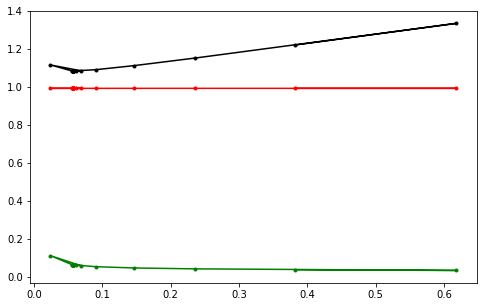

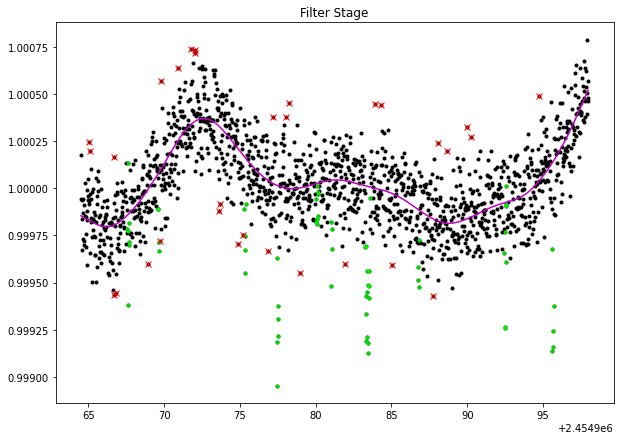

In [3737]:


smo_h, lsq_h, c1_h, c2_h = [], [], [], []

def min_smo_OLD(smo, time, flux, weights, transit_idx, fit_sds, sigma, vs):
    
    global smo_h, lsq_h
    
    smo = smo / vs
    
    #print(smo)
    
    # Make the fit
    cont_fit_tmp = iter_filt_ssfit(time, 
                                   flux, 
                                   weights, 
                                   ~transit_idx, 
                                   smo, 
                                   sds=fit_sds, 
                                   return_filt_index=0, 
                                   plot_q=0)

    # Measure the fit reliabillity based on some metric
#     bics = meas_sigdif(time, 
#                        flux, 
#                        weights, 
#                        cont_fit_tmp, 
#                        sigma_i=sigma)

    sigma_f = rms(flux - cont_fit_tmp)
    
    bics = (sigma - sigma_f)**2
    
    smo_h.append(smo)
    lsq_h.append(bics)
    
    return bics


def min_smo(smo, time, flux, weights, transit_idx, fit_sds, sigma, vs, t_bins0):
    
    global smo_h, lsq_h
    
    smo = smo / vs
    
    # Make the fit
    cont_fit_tmp, bi = iter_filt_ssfit(time, 
                                       flux, 
                                       weights, 
                                       ~transit_idx, 
                                       smo, 
                                       sds=fit_sds, 
                                       return_filt_index=1, 
                                       plot_q=0)
    
    gif = ~bi
    
    t_bins = t_bins0[gif]
    
    df = flux[gif] - cont_fit_tmp[gif]
    
    sigma_f = rms(df)
    
    dtb = np.zeros(np.max(t_bins)+1, dtype=float)
    
    for i in range(np.max(t_bins)+1):
        
        gi = t_bins == i
        
        ti = df[gi] > 0
        bi = df[gi] < 0
        
        #dtb[i] = np.abs(np.sum(df[gi][ti]) + np.sum(df[gi][bi]))
        
        a = np.sum(df[gi][ti]) + 1e-6
        
        b = np.sum(df[gi][bi]) + 1e-6
        
        dtb[i] = np.abs(1 - np.abs(a / b))
        
    w1 = 100
    #c1 = (sigma - sigma_f)**2
    c1 = np.abs(1 - np.abs(sigma + 1e-6 / (sigma_f + 1e-6)))
    
    w2 = 1
    #c2 = np.sum(dtb)
    c2 = np.sum(dtb) / len(dtb)
    
    #print(c1, c2, smo, np.sum(dtb) , len(dtb))
    
    #bics = w1 * c1 + w2 * c2
    
    bics = c1 * 1.0 + c2 * 1.0 + smo * 0.5  #**1.3036
    
    #bics = c1 * c2#$* np.abs(smo - 0.5)**0.1  #**1.3036
    
    #bics = np.sum(dtb)
    
    c1_h.append(c1)
    c2_h.append(c2)
    smo_h.append(smo)
    lsq_h.append(bics)
    
    return bics
    
#45, 52

cn = 0

vs = 1000

mask_transit_q = 1

fit_sds = [7, 5, 3, 2.5]

#smooth_bnds = [0.0*vs, 0.5*vs]
smooth_bnds = [0.0*vs, 1.0*vs]
# smooth_bnds = [0.998*vs, 1.0*vs]
#smooth_bnds = [0.9*vs, 1.0*vs]

# Mask the transit
if mask_transit_q:

    transit_idx = mask_mulit_transits(all_t0_bkjd, 
                                      all_period_day, 
                                      duration_day=all_duration_day, 
                                      time_bkjd=all_time[cn], 
                                      flux=all_flux[cn], 
                                      lc=None, 
                                      return_index=True)

else:

    transit_idx = np.zeros(len(all_time[cn]), dtype=bool)

weights = np.float64(~transit_idx)

weights[weights==0.0] = 1e-5

#sigma = meas_sig(all_time[cn], all_flux[cn], weights, plot_q=1)

sigma = rms(np.diff(all_flux[cn][~transit_idx]))


mdt = np.median(np.abs(np.diff(all_time[cn])))

if (len(all_time[cn]) > 500):# & (all_time[cn][-1] - all_time[cn][0] < 1.5):

    dt = mdt * 100

elif len(all_time[cn]) < 50:
    
    dt = mdt * 10

elif all_time[cn][-1] - all_time[cn][0] < 1.5:

    dt = (all_time[cn][-1] - all_time[cn][0]) / 4
    
elif all_time[cn][-1] - all_time[cn][0] < 5:
    
    #dt = np.median(np.abs(np.diff(all_time[cn]))) * 10.1
    dt = (all_time[cn][-1] - all_time[cn][0]) / 4
    #dt = all_time[cn][-1] - all_time[cn][0]
else:
    dt = 1
    #dt = mdt * 30
    
dt = 5

bins = np.arange(all_time[cn][0], all_time[cn][-1] + 1, dt)

t_bins = np.digitize(all_time[cn], bins) - 1


res = minimize_scalar(min_smo, 
                      bounds=tuple(smooth_bnds), 
                      method='bounded', 
                      #method='golden', 
                      args=(all_time[cn], 
                          all_flux[cn], 
                          weights, 
                          transit_idx, 
                          fit_sds, 
                          sigma, vs, t_bins))


res.x = res.x / vs

print(res)

bsmo = res.x

# for smo in np.linspace(1e-5, 1-1e-5, 10):
    
#     min_smo(smo * vs, all_time[cn], 
#           all_flux[cn], 
#           weights, 
#           transit_idx, 
#           fit_sds, 
#           sigma, vs, t_bins)


plt.figure(figsize=(8, 5))
plt.plot(smo_h, lsq_h, '.-k')
plt.plot(smo_h, c1_h, '.-r')
plt.plot(smo_h, c2_h, '.-g')


# Make the final fit using the solved smoothing param
cont_fit_tmp, outliers_tmp = iter_filt_ssfit(all_time[cn], 
                                             all_flux[cn], weights, 
                                             ~transit_idx, 
                                             bsmo, sds=fit_sds, 
                                             return_filt_index=1, 
                                             plot_q=1)




In [3738]:
dt, len(all_time[cn]), all_time[cn][-1] - all_time[cn][0],  dt / mdt

(5, 1496, 33.47115629678592, 244.6881248069114)

In [3739]:
np.linspace(1e-5, 1-1e-5, 10)

array([1.00000000e-05, 1.11118889e-01, 2.22227778e-01, 3.33336667e-01,
       4.44445556e-01, 5.55554444e-01, 6.66663333e-01, 7.77772222e-01,
       8.88881111e-01, 9.99990000e-01])

In [3747]:
mask_transit_q = True

fit_sds = [7, 5, 3] # Fitting iterative SD filter multiplers

#smooth_params_to_try = np.linspace(0.9, 1-1e-8, 200)[:-1]

#smooth_params_to_try = np.linspace(0.0001, 0.8, 200)[:-1]

smooth_bnds = [0.0, 0.2] # Smoothing param range allowed
# smooth_bnds = [0.999998, 1.0] # Smoothing param range allowed
# smooth_bnds = [0.998, 0.999] # Smoothing param range allowed

solver_var_scaler = 100 # Dont touch. Does nothing, b.


smooth_bnds = [smooth_bnds[0] * solver_var_scaler, smooth_bnds[1] * solver_var_scaler]

####################################################################################
# Fit each section

#smos = np.copy(smooth_params_to_try) #np.linspace(0.999, 1-1e-10, 200)

cont_fit, time_norm, flux_norm, outliers = np.array([]), np.array([]), np.array([]), np.array([])

cont_fit_list, flux_norm_list, outliers_list = [], [], []

sigs, ssmos = [], []

for cn in range(len(all_time)):
#for cn in range(20):

    #print(cn)

    # Mask the transit
    if mask_transit_q:

#         transit_idx = mask_transits(t0_bkjd=t0, period_day=p, duration_day=duration, 
#                                     time_bkjd=all_time[cn], 
#                                     flux=all_flux[cn], 
#                                     lc=None, return_index=True)
        
        transit_idx = mask_mulit_transits(all_t0_bkjd, all_period_day, 
                                          duration_day=all_duration_day, 
                                          time_bkjd=all_time[cn], 
                                          flux=all_flux[cn], 
                                          lc=None, 
                                          return_index=True)
        
    else:

        transit_idx = np.zeros(len(all_time[cn]), dtype=bool)


    #bics = np.ones_like(smos)
    
    weights = np.float64(~transit_idx)
        
    weights[weights==0.0] = 1e-5
    
    #print(len(all_time[cn]), len(all_flux[cn]), len(weights))

    #sigma = meas_sig(all_time[cn], all_flux[cn], weights, plot_q=0)
    
    sigma = rms(np.diff(all_flux[cn][~transit_idx]))

    mdt = np.median(np.abs(np.diff(all_time[cn])))

    
    if (len(all_time[cn]) > 500):# & (all_time[cn][-1] - all_time[cn][0] < 1.5):

        dt = mdt * 100
        
    elif len(all_time[cn]) < 50:

        dt = mdt * 10

    elif all_time[cn][-1] - all_time[cn][0] < 1.5:

        dt = (all_time[cn][-1] - all_time[cn][0]) / 4

    elif all_time[cn][-1] - all_time[cn][0] < 5:

        #dt = np.median(np.abs(np.diff(all_time[cn]))) * 10.1
        dt = (all_time[cn][-1] - all_time[cn][0]) / 4
    else:
        dt = 1 #mdt * 30
        
        
    dt = 5

    bins = np.arange(all_time[cn][0], all_time[cn][-1] + 1, dt)

    t_bins = np.digitize(all_time[cn], bins) - 1
    
    sigs.append(sigma)
    

    res = minimize_scalar(min_smo, 
                          bounds=tuple(smooth_bnds), 
                          method='bounded', 
                          args=(all_time[cn], 
                                  all_flux[cn], 
                                  weights, 
                                  transit_idx, 
                                  fit_sds, 
                                  sigma, 
                                solver_var_scaler, t_bins))

    #print(res)

    bsmo = res.x / solver_var_scaler
    
    ssmos.append(bsmo)


    # Make the final fit using the solved smoothing param
    cont_fit_tmp, outliers_tmp = iter_filt_ssfit(all_time[cn], 
                                                 all_flux[cn], 
                                                 weights, 
                                                 ~transit_idx, 
                                                 bsmo, sds=fit_sds, 
                                                 return_filt_index=1, 
                                                 plot_q=0)
    
    #print(len(all_time[cn]), len(cont_fit_tmp))


    flux_norm_tmp = all_flux[cn] / cont_fit_tmp


    cont_fit_list.append(cont_fit_tmp)

    flux_norm_list.append(flux_norm_tmp)

    outliers_list.append(outliers_tmp)
    
sigs = np.array(sigs)
ssmos = np.array(ssmos)

print('Done')

Done


In [3748]:
end_clip = 30

cont_fit, time_norm, flux_norm, outliers = np.array([]), np.array([]), np.array([]), np.array([])

for cn in range(len(all_time)):
    
    time_norm = np.concatenate((time_norm, all_time[cn][end_clip:-end_clip]))

    cont_fit = np.concatenate((cont_fit, cont_fit_list[cn][end_clip:-end_clip]))

    flux_norm = np.concatenate((flux_norm, flux_norm_list[cn][end_clip:-end_clip]))

    outliers = np.concatenate((outliers, outliers_list[cn][end_clip:-end_clip]))

In [3749]:
sigs

array([0.00021499, 0.00021115, 0.00022442, 0.00022479, 0.00024133,
       0.00020887, 0.00020039, 0.00020593, 0.00021714, 0.00023148,
       0.00023041, 0.00021946, 0.00021994, 0.0002155 , 0.00020735,
       0.0002228 , 0.00021532, 0.00021607, 0.00021303, 0.00021019,
       0.00021312, 0.00022549, 0.0002172 , 0.00021331, 0.00021608,
       0.0001973 , 0.00020529, 0.00022753, 0.00023519, 0.00023559,
       0.00020062, 0.00020783, 0.00021121, 0.00021299, 0.00022949,
       0.00026714, 0.00022875, 0.00021291, 0.00025478, 0.00021632,
       0.0002081 , 0.00020883, 0.0001913 , 0.00024653, 0.00021279,
       0.00022867, 0.00022521, 0.00022084, 0.00021668, 0.00021765,
       0.0002206 , 0.00020644, 0.00021395, 0.00022226, 0.00021383,
       0.00021925], dtype=float32)

In [3750]:
ssmos

array([5.35510006e-02, 3.12984402e-02, 2.52996021e-02, 6.44686410e-02,
       6.64374795e-08, 5.47391934e-02, 5.12648472e-02, 4.15611895e-02,
       6.99327688e-02, 9.23807589e-02, 1.97904115e-02, 7.15306552e-02,
       6.22847445e-02, 8.90007143e-02, 1.19143296e-02, 4.44037165e-02,
       7.50237692e-02, 1.16003888e-03, 8.47845262e-02, 9.64126222e-02,
       6.64312634e-02, 8.55109364e-02, 7.12013290e-02, 6.07775850e-02,
       1.18073198e-01, 5.49566435e-02, 1.04698802e-01, 1.76214857e-01,
       5.47655739e-02, 6.38154975e-02, 1.17425560e-01, 6.42959047e-02,
       6.92206431e-02, 1.24472093e-02, 2.96076795e-02, 6.64374795e-08,
       6.64374795e-08, 5.90063866e-02, 8.41144012e-02, 6.22860127e-02,
       5.60046597e-02, 7.78436596e-02, 9.19754924e-02, 1.36387359e-01,
       1.11919544e-01, 1.16197002e-01, 6.17841364e-02, 8.82839027e-03,
       1.31912196e-02, 4.75015039e-02, 7.60871759e-02, 1.99999934e-01,
       9.48879499e-02, 9.79894354e-02, 8.29197739e-02, 6.64374795e-08])

In [3751]:
np.where(ssmos > 0.8)

(array([], dtype=int64),)

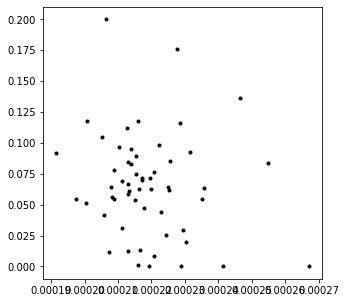

In [3752]:
plt.figure(figsize=(5, 5))
plt.plot(sigs, ssmos, '.k')

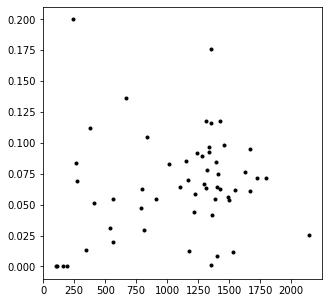

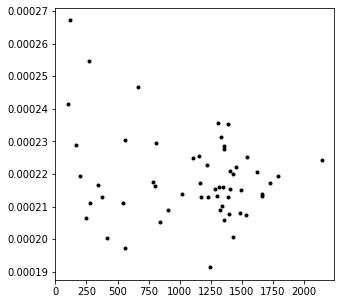

In [3753]:
plt.figure(figsize=(5, 5))
plt.plot([len(all_time[i]) for i in range(len(all_time))], ssmos, '.k')


plt.figure(figsize=(5, 5))
plt.plot([len(all_time[i]) for i in range(len(all_time))], sigs, '.k')

In [3754]:
len(time_norm), len(cont_fit), len(flux_norm), len(outliers)

(57528, 57528, 57528, 57528)

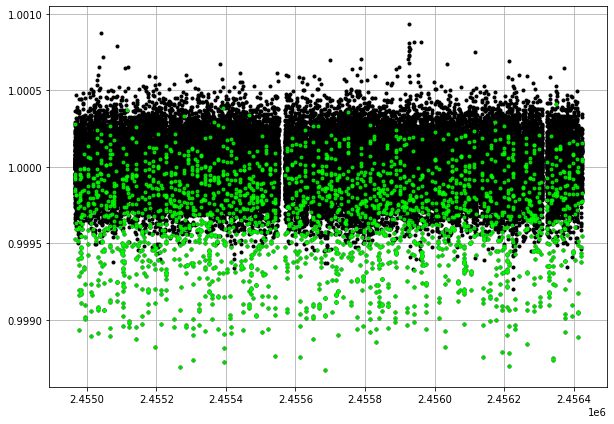

In [3755]:
if plot_q:
        
    # Mask the transit
    if mask_transit_q:

#         transit_idx = mask_transits(t0_bkjd=t0, period_day=p, duration_day=duration, 
#                                     time_bkjd=time_norm, flux=flux_norm, 
#                                     lc=None, return_index=True)
        
        transit_idx = mask_mulit_transits(all_t0_bkjd, all_period_day, 
                                          duration_day=all_duration_day, 
                                          time_bkjd=time_norm, 
                                          flux=flux_norm, 
                                          lc=None, return_index=True)
        
    else:

        transit_idx = np.zeros(len(all_time[cn]), dtype=bool)

    plt.figure(figsize=(10, 7))

    #plt.plot(time_norm, flux_norm, '.k')
    plt.plot(time_norm, flux_norm, '.k')

    if mask_transit_q:
        plt.plot(time_norm[transit_idx], 
                 flux_norm[transit_idx], '.', 
                 c=[0,1,0,0.8], 
                 label='Transit (Area Masked During Fit)')

    plt.grid(1)
    plt.show()

In [3756]:
time[0], time_norm[0]

(2454964.5127595193, 2454965.166656552)

In [3757]:
len(time), len(time_norm)

(60888, 57528)

In [3758]:
len(time_norm), len(flux[gi])

(57528, 1)

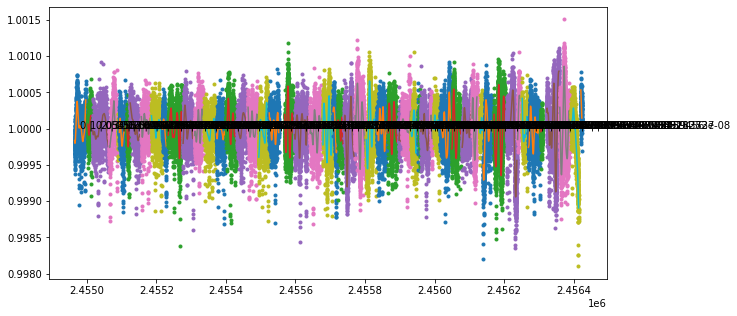

In [3759]:
outliers = np.int8(outliers)

_, gi, _ = np.intersect1d(time, time_norm, return_indices=1)

gi = np.sort(gi)

plt.figure(figsize=(10, 5))

for cn in range(len(all_time)):
    
    t = all_time[cn][end_clip:-end_clip]
    f = all_flux[cn][end_clip:-end_clip]
    c = cont_fit_list[cn][end_clip:-end_clip]
    
    plt.plot(t, f, '.', t, c, '-')
    plt.text(np.mean(t), 1, str(cn) + ' | ' + str(ssmos[cn]), fontsize=10)

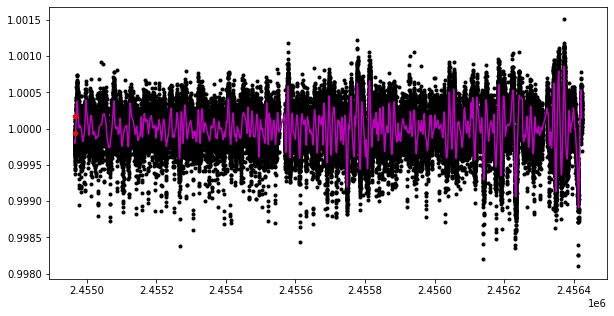

In [3760]:
outliers = np.int8(outliers)

_, gi, _ = np.intersect1d(time, time_norm, return_indices=1)

gi = np.sort(gi)

plt.figure(figsize=(10, 5))
plt.plot(time_norm, flux[gi], '.k')
plt.plot(time_norm, cont_fit, '-m')
plt.plot(time_norm[outliers], flux[outliers], '.r')

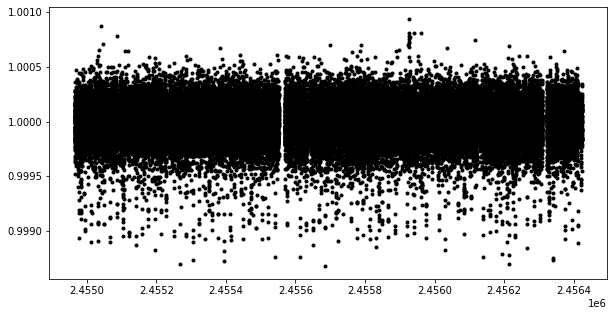

In [3761]:
plt.figure(figsize=(10, 5))
plt.plot(time_norm, flux_norm, '.k')

In [3698]:
# np.savez('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/' + str(target_name) + '_nofilt.npz', flux=flux_norm, time=time_norm)

In [3699]:
# loaded_file = np.load('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/' + str(target_name) + '_nofilt.npz')
# timetest =  loaded_file['time']
# fluxtest =  loaded_file['flux'] 

# plt.plot(timetest, fluxtest, '.k')

In [3762]:
# REMOVING ALL TRANSITS BY STRAIGHT UP DELETING

transit_idx = mask_mulit_transits(all_t0_bkjd, all_period_day, 
                                          duration_day=all_duration_day, 
                                          time_bkjd=time_norm, 
                                          flux=flux_norm, 
                                          lc=None, return_index=True)



In [3764]:
flux_transitsdeleted = flux_norm[~transit_idx]
time_transitsdeleted = time_norm[~transit_idx]
# yeett = time_norm[~transit_idx]
len(time_transitsdeleted), len(flux_transitsdeleted)

(55298, 55298)

In [3765]:
np.savez('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/' + str(target_name) + '_rmalltransits.npz', flux=flux_transitsdeleted, time=time_transitsdeleted)

In [3700]:
# other_target_idx = np.setdiff1d(np.arange(len(all_t0_bkjd)), interest_idx)
# print(other_target_idx)

# print(len(transit_idx))

[]
57111


[False False False ... False False False]
0


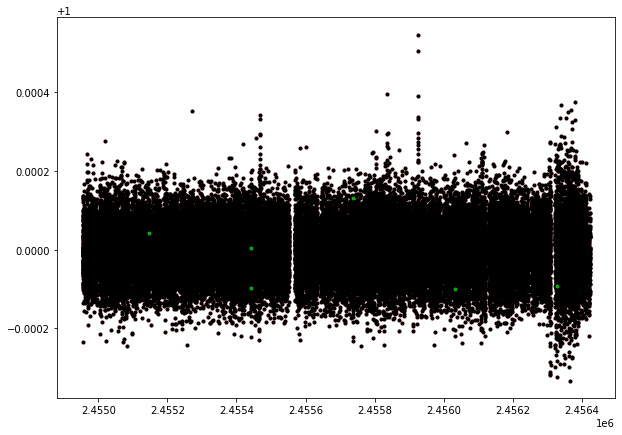

In [3701]:
# REMOVING ALL OTHER TRANSITS BY REPLACING WITH 1'S 

# # itemindex = np.where(transit_idx == True)

# transit_idx2 = mask_mulit_transits(np.array(all_t0_bkjd)[other_target_idx], 
#                                       np.array(all_period_day)[other_target_idx],
#                                       duration_day=np.array(all_duration_day)[other_target_idx],
#                                       time_bkjd=time_norm, 
#                                       flux=flux_norm, 
#                                       lc=None, return_index=True)
# print(transit_idx2)

# itemindex = np.where(transit_idx2 == True)

# # print(itemindex)
# print(len(itemindex[0]))

# flux_notransits = np.copy(flux_norm)

# np.put(flux_notransits, itemindex[0], np.ones(len(transit_idx2)))

# plt.figure(figsize=(10, 7))
# plt.plot(time_norm, flux_norm, '.r', alpha=0.4)
# plt.plot(time_norm, flux_notransits, '.k')
# plt.plot(time_norm[transit_idx], 
#                  flux_norm[transit_idx], '.', 
#                  c=[0,1,0,0.8], alpha=0.6,
#                  label='Transit (Area Masked During Fit)')
# plt.plot(time_norm[transit_idx2], 
#                  flux_norm[transit_idx2], '.b', alpha=0.4,
#                  label='Transit (Area Masked During Fit)')
# plt.savefig('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/foldfigs/filtered/' + str(target_name) + '_transitshighlighted.png')

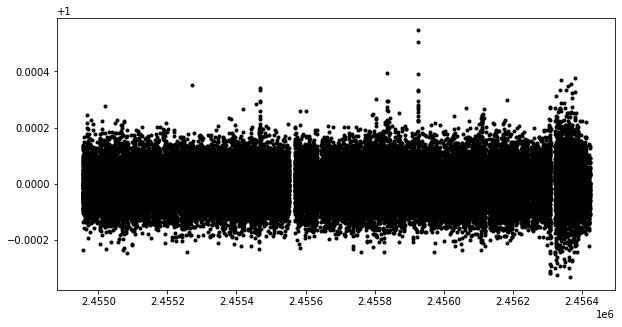

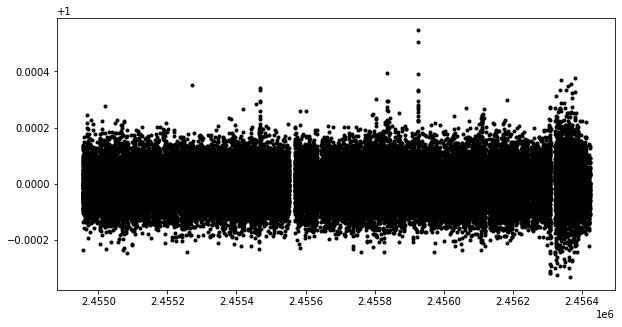

In [3702]:
plt.figure(figsize=(10, 5))
plt.plot(time_norm, flux_norm, '.k')
plt.savefig('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/foldfigs/filtered/' + str(target_name) + '_nofilter.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time_norm, flux_notransits, '.k')
plt.savefig('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/foldfigs/filtered/' + str(target_name) + '_filter.png')
plt.show(block=False)

In [3703]:
np.savez('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/' + str(target_name) + '_filt.npz', flux=flux_notransits, time=time_norm)

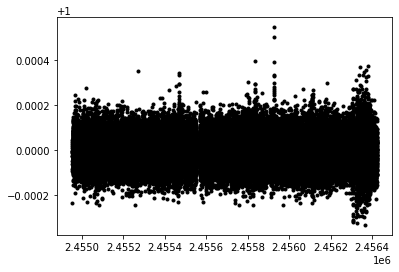

In [3704]:
loaded_file = np.load('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/' + str(target_name) + '_filt.npz')
timetest =  loaded_file['time']
fluxtest =  loaded_file['flux'] 

plt.plot(timetest, fluxtest, '.k')

In [3705]:
def signal(time_array, flux, period_id, t0=0.0, num_bins=8192):

    from kepler_utils import phase_fold_time, global_view
    
    time_array = phase_fold_time(time_array, period_id, t0)
    sorted_i = np.argsort(time_array)
    time_array = time_array[sorted_i]
    flux = flux[sorted_i]

    global_view = global_view(time_array, flux, period_id, num_bins=num_bins)
    
    t = np.linspace(np.min(time_array), np.max(time_array), num_bins)

    return t, global_view


def signal_no_bin(time_array, flux, period_id, t0):
    
    from kepler_utils import phase_fold_time

    time_array = phase_fold_time(time_array, period_id, t0)
    sorted_i = np.argsort(time_array)
    time_array = time_array[sorted_i]
    flux = flux[sorted_i]

    return time_array, flux

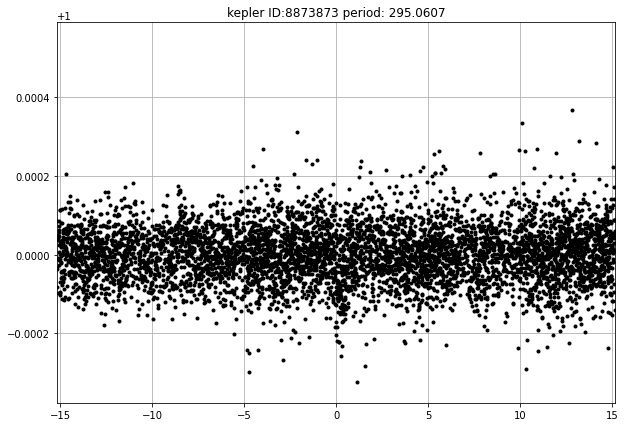

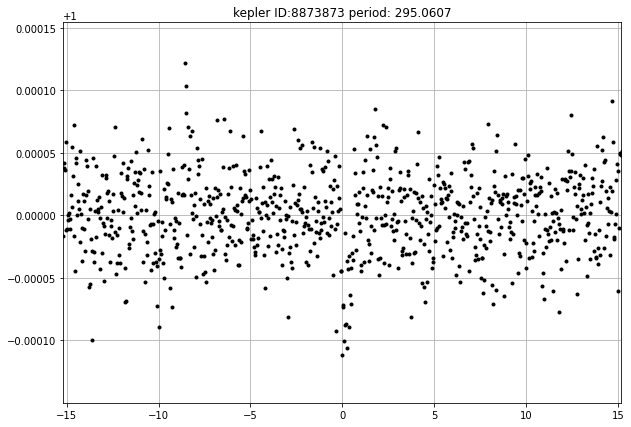

In [3706]:
time_tmp = np.copy(time_norm)
flux_tmp = np.copy(flux_notransits)

# Fold with no binning
t_bin, f_bin = signal_no_bin(time_tmp, flux_tmp, all_period_day[interest_idx], t0=all_t0_bkjd[interest_idx])
#t_bin, f_bin = signal_no_bin(time_tmp, flux_tmp, p, t0=t0)

# Fold then bin
# t_fold, f_fold = signal(time_tmp, flux_tmp, all_period_day[interest_idx], t0=all_t0_bkjd[interest_idx], num_bins=500)
t_fold, f_fold = signal(time_tmp, flux_tmp, all_period_day[interest_idx], t0=all_t0_bkjd[interest_idx], num_bins=8192)

params_str = 'P='+ str(np.around(all_period_day[interest_idx], 1)) + '  t0='+ str(np.around(all_t0_bkjd[interest_idx], 1)) + '  d='+ str(np.around(all_duration_day[interest_idx], 3))

lim = 15*6*6

plt.figure(figsize=(10,7))
# plt.title(target_name + ' | ' + params_str + ' | Folded Transit')
plt.plot(t_bin, f_bin, '.k')
plt.grid(1)
#plt.xlim(-5, 5)
plt.xlim(-all_duration_day[interest_idx] * lim, all_duration_day[interest_idx] * lim)
# plt.xlim(-all_duration_day[interest_idx] * 6.5, all_duration_day[interest_idx] * 6.5)
plt.title("kepler ID:" + str(target_name) + ' period: ' + str(all_period_day[interest_idx]))
plt.savefig('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/foldfigs/filtered/' + str(target_name) + '_filt0.png')
plt.show(block=False)
#plt.close()


plt.figure(figsize=(10,7))
# plt.title(target_name + ' | ' + params_str + ' | Folded & Binned Transit')
plt.plot(t_fold, f_fold, '.k')
plt.grid(1)
plt.xlim(-all_duration_day[interest_idx] * lim, all_duration_day[interest_idx] * lim)
plt.title("kepler ID:" + str(target_name) + ' period: ' + str(all_period_day[interest_idx]))
plt.savefig('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/foldfigs/filtered/' + str(target_name) + '_filt1.png')
plt.show(block=False)
#plt.show()

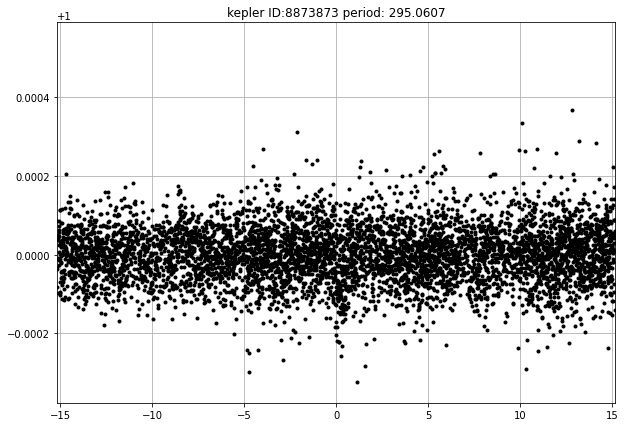

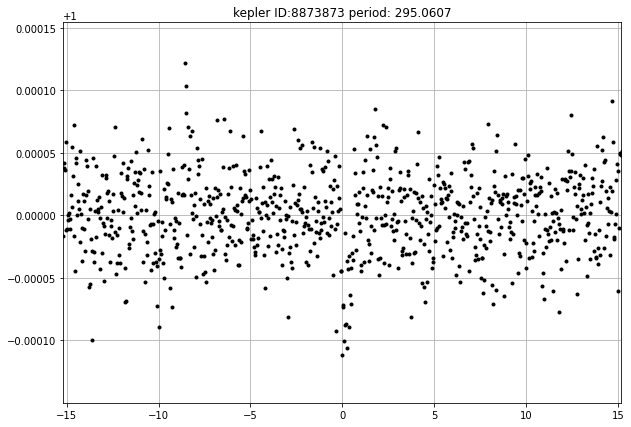

In [3707]:
time_tmp = np.copy(time_norm)
flux_tmp = np.copy(flux_norm)

# Fold with no binning
t_bin, f_bin = signal_no_bin(time_tmp, flux_tmp, all_period_day[interest_idx], t0=all_t0_bkjd[interest_idx])
#t_bin, f_bin = signal_no_bin(time_tmp, flux_tmp, p, t0=t0)

# Fold then bin
# t_fold, f_fold = signal(time_tmp, flux_tmp, all_period_day[interest_idx], t0=all_t0_bkjd[interest_idx], num_bins=500)
t_fold, f_fold = signal(time_tmp, flux_tmp, all_period_day[interest_idx], t0=all_t0_bkjd[interest_idx], num_bins=8192)

params_str = 'P='+ str(np.around(all_period_day[interest_idx], 1)) + '  t0='+ str(np.around(all_t0_bkjd[interest_idx], 1)) + '  d='+ str(np.around(all_duration_day[interest_idx], 3))

lim = 15*6*6

plt.figure(figsize=(10,7))
# plt.title(target_name + ' | ' + params_str + ' | Folded Transit')
plt.plot(t_bin, f_bin, '.k')
plt.grid(1)
#plt.xlim(-5, 5)
plt.xlim(-all_duration_day[interest_idx] * lim, all_duration_day[interest_idx] * lim)
# plt.xlim(-all_duration_day[interest_idx] * 6.5, all_duration_day[interest_idx] * 6.5)
plt.title("kepler ID:" + str(target_name) + ' period: ' + str(all_period_day[interest_idx]))
plt.savefig('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/foldfigs/' + str(target_name) + '_0.png')
plt.show(block=False)
#plt.close()


plt.figure(figsize=(10,7))
# plt.title(target_name + ' | ' + params_str + ' | Folded & Binned Transit')
plt.plot(t_fold, f_fold, '.k')
plt.grid(1)
plt.xlim(-all_duration_day[interest_idx] * lim, all_duration_day[interest_idx] * lim)
plt.title("kepler ID:" + str(target_name) + ' period: ' + str(all_period_day[interest_idx]))
plt.savefig('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/foldfigs/' + str(target_name) + '_1.png')
plt.show(block=False)
#plt.show()